In [1]:
# ==============================================================
# CELLA 1: Setup e configurazione
# ==============================================================

import sys
import subprocess
import os
import yaml
import torch
import random
import numpy as np
from pathlib import Path
from tqdm import tqdm
from PIL import Image
from torchvision import transforms
from torch.utils.data import DataLoader, random_split, Dataset
from torchvision.datasets import CIFAR10
from sentence_transformers import SentenceTransformer
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models

# --- ✅ AGGIORNAMENTO LIBRERIA GEMINI (da eseguire PRIMA della Cella 1.5) ---
# Serve per evitare l'errore "models/gemini-1.5-flash not found for API version v1beta"
!pip install -U google-generativeai -q
# ---------------------------------------------------------------------------

# Google Drive (opzionale)
IN_COLAB = 'google.colab' in sys.modules
DRIVE_MOUNT_POINT = '/content/drive'
if IN_COLAB:
    from google.colab import drive
    try:
        drive.mount(DRIVE_MOUNT_POINT, force_remount=True)
        DRIVE_SAVE_DIR = Path(DRIVE_MOUNT_POINT) / 'MyDrive' / 'VQA_Lite'
        DRIVE_SAVE_DIR.mkdir(parents=True, exist_ok=True)
    except Exception:
        DRIVE_SAVE_DIR = Path('.')
else:
    DRIVE_SAVE_DIR = Path('.')

# Installa dipendenze
required_pkgs = [
    'sentence-transformers',
    'tqdm',
    'PyYAML',
    'grad-cam',
    'opencv-python-headless',
    'matplotlib',
    # --- AGGIUNTE PER RAG ---
    'faiss-cpu'  # (non serve reinstallare google-generativeai: già aggiornato sopra)
]

if IN_COLAB or '--force-install' in sys.argv:
    print(f"\n⚙️ Installazione/Verifica librerie: {', '.join(required_pkgs)}...")
    subprocess.check_call([sys.executable, '-m', 'pip', 'install', '-q', '-U'] + required_pkgs)
    print("✅ Installazione completata.")

# --- Verifica Versioni ---
print('\n--- Informazioni Ambiente ---')
print('Python:', sys.version.split()[0])
print('Torch:', torch.__version__)
print('CUDA available:', torch.cuda.is_available())

# --- Configurazione Globale (cfg) ---
CIFAR10_CLASSES = ["aeroplano", "automobile", "uccello", "gatto", "cervo", "cane", "rana", "cavallo", "nave", "camion"]
cfg = {
    'device': 'cuda' if torch.cuda.is_available() else 'cpu',
    'model': {
        'question_dim': 384,
        'image_feature_dim': 256,
        'attention_hidden_dim': 128,
        'dropout': 0.3,
    },
    'answers': CIFAR10_CLASSES,
    'categories': {'animale':[2,3,4,5,6,7],'veicolo':[0,1,8,9]},
    'training': {
        'batch_size': 256,
        'epochs': 10,
        'learning_rate': 5e-3,
        'weight_decay': 1e-4,
        'val_split': 0.1,
        'seed': 42,
        'num_workers': 2 if IN_COLAB else 4,
    },
    'paths': {
        'model_save_path': str(DRIVE_SAVE_DIR / 'vqa_model_best.pth'),
        'data_dir': 'data',
        'train_npz': str(DRIVE_SAVE_DIR / 'train_dataset_full.npz'),
        'test_npz': str(DRIVE_SAVE_DIR / 'test_dataset_full.npz')
    },
    'embedding_model': 'all-MiniLM-L6-v2'
}

DEVICE = cfg['device']
DATA_DIR = cfg['paths']['data_dir']
Path(DATA_DIR).mkdir(exist_ok=True)

print(f"Dispositivo selezionato: {DEVICE}")
print(f"Path salvataggio modello: {cfg['paths']['model_save_path']}")
print(f"Path NPZ Train: {cfg['paths']['train_npz']}")
print(f"Path NPZ Test: {cfg['paths']['test_npz']}")


Mounted at /content/drive

⚙️ Installazione/Verifica librerie: sentence-transformers, tqdm, PyYAML, grad-cam, opencv-python-headless, matplotlib, faiss-cpu...
✅ Installazione completata.

--- Informazioni Ambiente ---
Python: 3.12.12
Torch: 2.8.0+cu126
CUDA available: True
Dispositivo selezionato: cuda
Path salvataggio modello: /content/drive/MyDrive/VQA_Lite/vqa_model_best.pth
Path NPZ Train: /content/drive/MyDrive/VQA_Lite/train_dataset_full.npz
Path NPZ Test: /content/drive/MyDrive/VQA_Lite/test_dataset_full.npz


In [2]:
# CELLA 1.5: Setup Generatore (Google Gemini)

import google.generativeai as genai
from google.colab import userdata
import textwrap

# --- Configurazione API KEY ---
try:
    GEMINI_API_KEY = userdata.get('GEMINI_API_KEY')
    if GEMINI_API_KEY is None:
        raise ValueError("API Key non trovata")
    genai.configure(api_key=GEMINI_API_KEY)
    print("✅ API Key Gemini configurata.")
except Exception as e:
    print(f"🔴 Errore: GEMINI_API_KEY non trovata o non valida. {e}")
    print("   Vai su https://aistudio.google.com/ per crearne una e salvala nei Segreti di Colab (🔑).")
    GEMINI_API_KEY = None

# Modello Generativo
generation_config = {
  "temperature": 0.2,
  "top_p": 1,
  "top_k": 1,
  "max_output_tokens": 512,
}

if GEMINI_API_KEY:
    # MODIFICATO: Usiamo gemini-1.5-flash (il modello free tier più recente)
    gemini_model = genai.GenerativeModel(model_name="gemini-2.5-flash",
                                     generation_config=generation_config)

    print(f"✅ Modello Gemini ({gemini_model.model_name}) caricato.")
else:
    gemini_model = None
    print("⚠️ Modello Gemini non caricato a causa dell'API Key mancante.")

✅ API Key Gemini configurata.
✅ Modello Gemini (models/gemini-2.5-flash) caricato.


In [3]:
# CELLA 2: Trasformazioni immagine e utilità

def set_seed(seed: int) -> None:
    """Imposta seed per riproducibilità."""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

def get_image_transform(is_training: bool = False) -> transforms.Compose:
    """Restituisce trasformazioni per immagini.
    - Resize a 32x32 per inferenza
    - Augmentazioni solo durante il training
    """
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

    if is_training:
        return transforms.Compose([
            transforms.RandomCrop(32, padding=4),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            normalize,
        ])
    else:
        # Pre-processing per Validazione / Test / **Inferenza**
        # === CORREZIONE FONDAMENTALE ===
        # Forziamo *qualsiasi* immagine alla dimensione 32x32 attesa dal modello
        return transforms.Compose([
            transforms.Resize((32, 32), interpolation=transforms.InterpolationMode.BICUBIC), # Qualità resize
            transforms.ToTensor(),
            normalize,
        ])

set_seed(cfg['training']['seed'])


In [4]:
# CELLA 3: Modello VQANet

class VQANet(nn.Module):
    """Modello VQA basato su ResNet18 (Image Encoder) e Attention (Fusion)."""
    def __init__(self, num_answers, question_dim, image_feature_dim, attention_hidden_dim, dropout: float = 0.3):
        super().__init__()

        # Image Encoder: ResNet18 pre-addestrato
        backbone = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
        self.backbone = nn.Sequential(*list(backbone.children())[:-2]) # Rimuove AvgPool e FC finale

        # Proiezione feature immagine
        self.proj = nn.Conv2d(512, image_feature_dim, kernel_size=1)

        # Meccanismo di Attenzione
        self.attention_conv = nn.Conv2d(image_feature_dim + question_dim, attention_hidden_dim, 1)
        self.attention_fc = nn.Conv2d(attention_hidden_dim, 1, 1)

        # Classificatore finale
        self.fc = nn.Sequential(
            nn.Linear(image_feature_dim + question_dim, attention_hidden_dim),
            nn.ReLU(),
            nn.Dropout(p=dropout),
            nn.Linear(attention_hidden_dim, num_answers)
        )

    def forward(self, image, question_emb, temperature: float = 1.0):
        # 1. Image Encoding
        x = self.backbone(image)
        img_features = self.proj(x)
        B, C, H, W = img_features.shape # Dimensione attesa: (B, C, 1, 1) dopo ResNet su 32x32

        # 2. Fusion e Attenzione
        question_emb_expanded = question_emb.unsqueeze(-1).unsqueeze(-1).expand(B, -1, H, W)
        combined_features = torch.cat([img_features, question_emb_expanded], dim=1)

        attn_hidden = torch.tanh(self.attention_conv(combined_features))
        logits = self.attention_fc(attn_hidden).view(B, -1) # Flatten spaziale implicito
        logits = logits / max(temperature, 1e-6)
        attn_weights = F.softmax(logits, dim=1).view(B, 1, H, W)

        # 3. Applicazione Attenzione
        attended_img_vector = (attn_weights * img_features).sum(dim=[2, 3])

        # 4. Classificazione Finale
        final_combined = torch.cat([attended_img_vector, question_emb], dim=1)
        return self.fc(final_combined)

In [5]:
# CELLA 4: Preparazione dataset e NPZ

ANSWER_VOCAB = cfg['answers']
answer_to_idx = {a:i for i,a in enumerate(ANSWER_VOCAB)}

def create_indexed_dataset_full(dataset, description):
    indices = []
    questions = []
    targets = []
    for idx, (_, label) in enumerate(tqdm(dataset, desc=f"Preparazione {description}", ncols=100)):
        true_class_name = ANSWER_VOCAB[label]
        # Tipo 1: Domanda Sì/No
        indices.append(idx)
        questions.append(f"C'è un {true_class_name}?")
        targets.append(label)
        # Tipo 2: Domanda Aperta
        indices.append(idx)
        questions.append("Che oggetto c'è?")
        targets.append(label)
    return indices, questions, targets

#  Verifica Esistenza NPZ
TRAIN_NPZ_PATH = cfg['paths']['train_npz']
TEST_NPZ_PATH = cfg['paths']['test_npz']

# Carica sempre CIFAR (serve per VQADatasetNPZ nella Cella 5)
print("🔄 Caricamento CIFAR-10...")
train_set_cifar = CIFAR10(root=DATA_DIR, train=True, download=True)
test_set_cifar = CIFAR10(root=DATA_DIR, train=False, download=True)

# Carica modello embedding (serve per inferenza RAG nella Cella 8)
if 'embedding_model' not in globals() or embedding_model is None:
    print("🔄 Caricamento SentenceTransformer...")
    try:
        embedding_model = SentenceTransformer(cfg['embedding_model'], device='cpu')
    except Exception as e:
        print(f"🔴 Errore caricamento embedding_model: {e}")
        embedding_model = None


# --- LOGICA DI SKIP (RE-INSERITA) ---
if Path(TRAIN_NPZ_PATH).exists() and Path(TEST_NPZ_PATH).exists():
    # Corretto il path nel print, usa DRIVE_SAVE_DIR
    print(f"✅ File NPZ trovati in '{DRIVE_SAVE_DIR}'. Salto la rigenerazione.")
else:
    print(f"⚠️ File NPZ non trovati in '{DRIVE_SAVE_DIR}'. Rigenerazione in corso...")
    if embedding_model is None:
        print("🔴 Impossibile generare NPZ: modello embedding non caricato.")
    else:
        # Genera indici e domande
        train_indices, train_questions, train_targets = create_indexed_dataset_full(train_set_cifar, "Train FULL")
        test_indices, test_questions, test_targets = create_indexed_dataset_full(test_set_cifar, "Test FULL")

        # Calcola embedding (con la normalizzazione corretta per FAISS)
        print("🔄 Calcolo embedding domande (Train)...\n   (Verranno normalizzati per FAISS/Cosine Similarity)")
        train_emb = embedding_model.encode(train_questions, convert_to_numpy=True, show_progress_bar=True, batch_size=256, normalize_embeddings=True)
        print("🔄 Calcolo embedding domande (Test)...\n   (Verranno normalizzati per FAISS/Cosine Similarity)")
        test_emb = embedding_model.encode(test_questions, convert_to_numpy=True, show_progress_bar=True, batch_size=256, normalize_embeddings=True)

        # Conversione tipi + Salvataggio NPZ
        train_emb = train_emb.astype(np.float16)
        test_emb = test_emb.astype(np.float16)
        train_indices = np.asarray(train_indices, dtype=np.int32)
        test_indices = np.asarray(test_indices, dtype=np.int32)
        train_targets = np.asarray(train_targets, dtype=np.int16)
        test_targets = np.asarray(test_targets, dtype=np.int16)

        print("💾 Salvataggio NPZ compressi...")
        np.savez_compressed(TRAIN_NPZ_PATH, indices=train_indices, emb=train_emb, y=train_targets)
        np.savez_compressed(TEST_NPZ_PATH, indices=test_indices, emb=test_emb, y=test_targets)
        print(f"✅ Dataset salvati in {TRAIN_NPZ_PATH} e {TEST_NPZ_PATH}")

# Verifica finale caricamento embedding model
if 'embedding_model' not in globals() or embedding_model is None:
     print("🔴 ATTENZIONE: Il modello embedding non è stato caricato correttamente.")

🔄 Caricamento CIFAR-10...


100%|██████████| 170M/170M [00:04<00:00, 41.1MB/s]


🔄 Caricamento SentenceTransformer...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

✅ File NPZ trovati in '/content/drive/MyDrive/VQA_Lite'. Salto la rigenerazione.


In [6]:
# CELLA 5: Dataset e DataLoader

class VQADatasetNPZ(Dataset):
    def __init__(self, npz_path: str, cifar_dataset: CIFAR10, is_training: bool):
        data = np.load(npz_path)
        self.indices = data['indices']
        self.emb = data['emb']  # float16
        self.y = data['y']
        self.cifar = cifar_dataset
        self.transform = get_image_transform(is_training=is_training)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, i):
        img_idx = int(self.indices[i])
        img, _ = self.cifar[img_idx] # Carica PIL Image
        image = self.transform(img).float() # Applica transform (ToTensor, Resize se non training, Normalize)
        q = torch.from_numpy(self.emb[i].astype(np.float32)) # float16 -> float32
        y = int(self.y[i])
        return image, q, y

#  Creazione Dataset e DataLoader
try:
    train_ds_full = VQADatasetNPZ(cfg['paths']['train_npz'], cifar_dataset=train_set_cifar, is_training=True)
    test_ds = VQADatasetNPZ(cfg['paths']['test_npz'], cifar_dataset=test_set_cifar, is_training=False)
except NameError:
     print("🔴 Errore: 'train_set_cifar' o 'test_set_cifar' non definiti. Eseguire Cella 4.")
     train_ds_full, test_ds = None, None

if train_ds_full:
    # Split Train/Validation
    val_split = cfg['training']['val_split']
    val_size = max(1, int(len(train_ds_full) * val_split))
    train_size = len(train_ds_full) - val_size
    train_ds, val_ds = random_split(train_ds_full, [train_size, val_size])

    val_ds.dataset.transform = get_image_transform(is_training=False)

    # DataLoaders
    BS = cfg['training']['batch_size']
    NW = cfg['training']['num_workers']
    PIN = DEVICE == 'cuda'

    train_loader = DataLoader(train_ds, batch_size=BS, shuffle=True, num_workers=NW, pin_memory=PIN, persistent_workers=True if NW > 0 else False)
    val_loader = DataLoader(val_ds, batch_size=BS, shuffle=False, num_workers=NW, pin_memory=PIN, persistent_workers=True if NW > 0 else False)
    test_loader = DataLoader(test_ds, batch_size=BS, shuffle=False, num_workers=NW, pin_memory=PIN, persistent_workers=True if NW > 0 else False)

    print(f"Dataset: Train={train_size}, Val={val_size}, Test={len(test_ds)}")
    print(f"Dataloader: Batch Size={BS}, Num Workers={NW}")
else:
    print("🔴 DataLoaders non creati a causa di errore precedente.")

Dataset: Train=90000, Val=10000, Test=20000
Dataloader: Batch Size=256, Num Workers=2


In [7]:
# CELLA 6: Training e valutazione

def evaluate(model, loader, device):
    model.eval()
    total, correct = 0, 0
    with torch.no_grad():
        for images, q, y in tqdm(loader, desc="🔄 Valutazione", leave=False, ncols=100):
            images, q, y = images.to(device), q.to(device), y.to(device)
            out = model(images, q)
            pred = out.argmax(1)
            total += y.size(0)
            correct += (pred == y).sum().item()
    return 100.0 * correct / max(1, total)


#  Inizializzazione Architettura Modello
m_cfg = cfg['model']
num_answers = len(cfg['answers'])
model = VQANet(
    num_answers,
    m_cfg['question_dim'],
    m_cfg['image_feature_dim'],
    m_cfg['attention_hidden_dim'],
    dropout=m_cfg.get('dropout', 0.3)
).to(DEVICE)

model_save_path = cfg['paths']['model_save_path']
EPOCHS = cfg['training']['epochs']

#  LOGICA DI SKIP TRAINING
if Path(model_save_path).exists():
    print(f"✅ Modello pre-addestrato trovato in: {model_save_path}")
    try:
        model.load_state_dict(torch.load(model_save_path, map_location=DEVICE))
        print("✅ Pesi caricati correttamente. Salto il training.")
        best_acc = 0.0 # carica l'accuracy salvata se disponibile
    except Exception as e:
        print(f"🔴 Errore nel caricamento del modello pre-addestrato: {e}")
        print("   Procedo con il riaddestramento.")
        best_acc = 0.0
        run_training = True
    else:
        # Se il caricamento ha successo, salta il training
        run_training = False
else:
    print(f"⚠️ Modello pre-addestrato non trovato in {model_save_path}. Inizio training...")
    best_acc = 0.0
    run_training = True

#  Esegui Training (solo se run_training è True)
if run_training:
    if 'train_loader' not in globals() or 'val_loader' not in globals():
         print("🔴 Errore: Dataloaders non definiti. Eseguire Cella 5.")
    else:
        criterion = torch.nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(
            model.parameters(),
            lr=cfg['training']['learning_rate'],
            weight_decay=cfg['training'].get('weight_decay', 0.0)
        )

        print("\n--- Inizio Training Effettivo ---")
        for epoch in range(1, EPOCHS + 1):
            model.train()
            running_loss = 0.0
            train_pbar = tqdm(train_loader, desc=f"Epoch {epoch}/{EPOCHS} [Train]", ncols=100)

            for images, q, y in train_pbar:
                images, q, y = images.to(DEVICE), q.to(DEVICE), y.to(DEVICE)
                optimizer.zero_grad()
                out = model(images, q)
                loss = criterion(out, y)
                loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
                optimizer.step()
                running_loss += loss.item()
                train_pbar.set_postfix(loss=loss.item())

            val_acc = evaluate(model, val_loader, DEVICE)
            avg_loss = running_loss / len(train_loader)

            print(f"\n[Epoch {epoch}/{EPOCHS}] Loss: {avg_loss:.4f} | Val Acc: {val_acc:.2f}%")

            if val_acc > best_acc:
                best_acc = val_acc
                try:
                    torch.save(model.state_dict(), model_save_path)
                    print(f"💾 Modello salvato! Nuova best acc: {best_acc:.2f}% -> {model_save_path}")
                except Exception as e:
                    print(f"⚠️ Errore salvataggio modello: {e}")

        print(f"\n🏁 Training completato. Migliore Val Acc registrata: {best_acc:.2f}%")


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 193MB/s]


✅ Modello pre-addestrato trovato in: /content/drive/MyDrive/VQA_Lite/vqa_model_best.pth
✅ Pesi caricati correttamente. Salto il training.


In [8]:
# CELLA 7: Valutazione finale

model_save_path = cfg['paths']['model_save_path']
try:
    m_cfg = cfg['model']
    num_answers = len(cfg['answers'])
    model = VQANet(
        num_answers, m_cfg['question_dim'], m_cfg['image_feature_dim'],
        m_cfg['attention_hidden_dim'], dropout=m_cfg.get('dropout', 0.3)
    ).to(DEVICE)

    model.load_state_dict(torch.load(model_save_path, map_location=DEVICE))
    print(f"✅ Modello migliore caricato da: {model_save_path}")

    # Valuta su Test Set
    if 'test_loader' in globals():
        test_acc = evaluate(model, test_loader, DEVICE)
        print(f"\n📊 Accuracy Finale sul Test Set: {test_acc:.2f}%")
    else:
        print("🔴 Errore: Test loader non definito. Eseguire Cella 5.")

except FileNotFoundError:
    print(f"🔴 ATTENZIONE: File modello non trovato in '{model_save_path}'.")
    print("   Eseguire il training (Cella 6) o verificare il path su Google Drive.")
except Exception as e:
     print(f"🔴 Errore caricamento modello: {e}")

✅ Modello migliore caricato da: /content/drive/MyDrive/VQA_Lite/vqa_model_best.pth



📊 Accuracy Finale sul Test Set: 86.11%


In [9]:
# CELLA 7.5: Setup Retriever (FAISS Knowledge Base - VISUAL)

import faiss

print("🔄 Costruzione del Knowledge Base e Indice FAISS (VISIVO)...")

# Dati necessari (devono essere stati caricati/generati da Cella 4)
try:
    if 'train_set_cifar' not in globals():
         train_set_cifar = CIFAR10(root=DATA_DIR, train=True, download=True)
    if 'model' not in globals():
         print("🔴 Modello VQANet non ancora definito. Eseguire Cella 3 e 6/7.")
         raise NameError("Modello VQANet non definito")

    # 1. Estrattore di Feature Visive (il backbone del VQANet)
    # Assicuriamoci che il modello VQANet esista e sia addestrato/caricato
    visual_encoder = nn.Sequential(
        model.backbone, # ResNet18 fino a layer4 (output 512, 1, 1)
        model.proj,     # Proiezione (output 256, 1, 1)
        nn.AdaptiveAvgPool2d((1, 1)), # Pooling globale
        nn.Flatten()    # Output (B, 256)
    ).to(DEVICE).eval()

    # 2. Creazione Mappe Testuali (per il contesto RAG)
    # Dobbiamo mappare l'INDICE CIFAR (0-49999) alle sue domande/risposte
    kb_questions_map = {} # Dizionario {cifar_idx: [q1, q2]}
    kb_answers_map = {}   # Dizionario {cifar_idx: [a1, a2]}
    ANSWER_VOCAB = cfg['answers']

    for idx, (_, label) in enumerate(tqdm(train_set_cifar, desc="Generazione Mappa KB testuale", ncols=100)):
        true_class_name = ANSWER_VOCAB[label]
        kb_questions_map[idx] = [
            f"C'è un {true_class_name}?",
            "Che oggetto c'è?"
        ]
        kb_answers_map[idx] = [true_class_name, true_class_name]

    # 3. Vettorizzazione delle Immagini del KB (CIFAR Train)
    # Usiamo un DataLoader per processare le 50k immagini in batch
    transform_kb = get_image_transform(is_training=False)

    class CIFARKBDataset(Dataset):
        def __init__(self, cifar_ds, transform):
            self.cifar_ds = cifar_ds
            self.transform = transform
        def __len__(self):
            return len(self.cifar_ds)
        def __getitem__(self, i):
            img, _ = self.cifar_ds[i]
            return self.transform(img)

    kb_dataset = CIFARKBDataset(train_set_cifar, transform_kb)
    kb_loader = DataLoader(kb_dataset, batch_size=cfg['training']['batch_size'], shuffle=False, num_workers=2)

    kb_visual_embeddings = []
    print("🔄 Vettorizzazione Immagini KB (50k)...")
    with torch.no_grad():
        for imgs in tqdm(kb_loader, desc="Estrazione Feature Visive", ncols=100):
            imgs = imgs.to(DEVICE)
            features = visual_encoder(imgs) # (B, 256)
            kb_visual_embeddings.append(features.cpu().numpy())

    kb_visual_embeddings = np.concatenate(kb_visual_embeddings, axis=0).astype(np.float32)

    # 4. Costruisci l'indice FAISS (L2 per le feature visive)
    d = kb_visual_embeddings.shape[1] # Dimensione (256)
    index = faiss.IndexFlatL2(d)
    index.add(kb_visual_embeddings)

    print(f"✅ Indice FAISS (Visivo L2) costruito. {index.ntotal} vettori indicizzati.")

except Exception as e:
    print(f"🔴 Errore nella costruzione del KB/FAISS: {e}")
    index = None

# --- Funzione Retriever (VISIVA) ---
def retrieve_visual_context_from_kb(visual_features_np: np.ndarray, k: int = 3) -> str:
    """Cerca nel KB visivo e formatta il contesto testuale per il RAG."""

    if index is None:
        return "Errore: Indice Visivo non disponibile."

    if visual_features_np.ndim == 1:
        visual_features_np = np.expand_dims(visual_features_np, axis=0)

    # Cerca nel'indice FAISS
    distances, indices = index.search(visual_features_np.astype(np.float32), k)

    # Formatta il contesto
    context = "Ecco alcuni esempi di immagini *visivamente simili* recuperate dal database:\n"
    for i in range(k):
        cifar_idx = indices[0][i] # Indice dell'immagine CIFAR (0-49999)

        # Recupera le domande/risposte associate a quell'immagine
        q1 = kb_questions_map[cifar_idx][0]
        a1 = kb_answers_map[cifar_idx][0]
        dist = distances[0][i]

        context += f"- Esempio Simile {i+1} (Distanza L2: {dist:.2f}):\n"
        context += f"  Classe Immagine: '{a1}'\n"
        context += f"  Domanda Esempio: '{q1}'\n"
    return context

🔄 Costruzione del Knowledge Base e Indice FAISS (VISIVO)...


Generazione Mappa KB testuale: 100%|███████████████████████| 50000/50000 [00:01<00:00, 33784.58it/s]


🔄 Vettorizzazione Immagini KB (50k)...


Estrazione Feature Visive: 100%|██████████████████████████████████| 196/196 [00:11<00:00, 16.36it/s]

✅ Indice FAISS (Visivo L2) costruito. 50000 vettori indicizzati.



--- Test RAG su Immagine Specifica ---

DOMANDA UTENTE: "C'è un topo viola?"
IMMAGINE: /content/drive/MyDrive/VQA_Lite/test_images/test_image2.jpg
 Fase 1: Analisi Visiva (VQANet)...
 > Risultato VQANet: automobile (96.23%)

 Fase 2: Retrieval VISIVO dal Knowledge Base (FAISS)...
 > Contesto recuperato:
   Ecco alcuni esempi di immagini *visivamente simili* recuperate dal database:
   - Esempio Simile 1 (Distanza L2: 0.02):
     Classe Immagine: 'automobile'
     Domanda Esempio: 'C'è un automobile?'
   - Esempio Simile 2 (Distanza L2: 0.05):
     Classe Immagine: 'automobile'
     Domanda Esempio: 'C'è un automobile?'
   - Esempio Simile 3 (Distanza L2: 0.05):
     Classe Immagine: 'automobile'
     Domanda Esempio: 'C'è un automobile?'


 Fase 3: Generazione Risposta (Gemini API)...

--- 💡 RISPOSTA RAG FINALE ---
No, l'analisi dell'immagine indica la presenza di un'automobile.

DOMANDA UTENTE: "Che c'è un oggetto?"
IMMAGINE: /content/drive/MyDrive/VQA_Lite/test_images/test_image2.jp

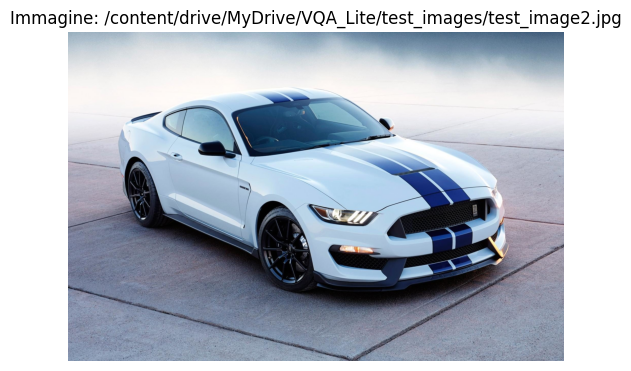

In [10]:
# CELLA 8: Inferenza RAG (Retrieval-Augmented Generation)

# --- 1. Funzione di Analisi Visiva Primaria (Modificata) ---
ANSWERS_VOCAB = cfg['answers']

def format_classification_answer(question: str, pred_idx: int) -> str:
    # (Funzione 'format_answer' originale)
    pred_class = ANSWERS_VOCAB[pred_idx]
    q = question.strip().lower()
    if q.startswith("c'è un ") or q.startswith("c'è una "):
        prefix_len = len("c'è un ") if q.startswith("c'è un ") else len("c'è una ")
        asked_class = q[prefix_len:-1].strip()
        return f"Sì, c'è un/una {pred_class}." if asked_class == pred_class else f"No, non c'è un/una {asked_class}. C'è un/una {pred_class}."
    if q.startswith("che "):
        return f"C'è un/una {pred_class}."
    return pred_class

def run_vqa_classification(image_path: str, question: str, model: VQANet, device: str):
    """
    Esegue VQA (Classificazione) e restituisce
    (risposta_formattata, classe_predetta, confidenza, visual_features_numpy)
    """
    global embedding_model, visual_encoder

    try:
        img = Image.open(image_path).convert('RGB')
        transform = get_image_transform(is_training=False)
        img_t = transform(img).unsqueeze(0).to(device).float()
    except Exception as e:
        return f"ERRORE Immagine: {e}", None, 0.0, None

    if 'embedding_model' not in globals() or embedding_model is None:
        return "ERRORE Modello Embedding", None, 0.0, None
    if 'visual_encoder' not in globals() or visual_encoder is None:
        return "ERRORE Visual Encoder (Cella 7.5)", None, 0.0, None

    # Embedding Testuale (NON normalizzato, per il VQANet)
    q_emb_np = embedding_model.encode(question, normalize_embeddings=False)
    if q_emb_np.ndim == 1: q_emb_np = np.expand_dims(q_emb_np, axis=0)
    q_emb_torch = torch.from_numpy(q_emb_np).to(device).float()

    model.eval()
    visual_encoder.eval()

    with torch.no_grad():
        # Estrazione Feature Visive (per FAISS)
        vis_feat_np = visual_encoder(img_t).cpu().numpy() # (1, 256)

        # Predizione VQA (per Analisi Primaria)
        out = model(img_t, q_emb_torch)
        probabilities = F.softmax(out, dim=1)
        pred_idx = out.argmax(1).item()
        pred_class = ANSWERS_VOCAB[pred_idx]
        confidence = probabilities[0, pred_idx].item() * 100.0

    formatted_answer = format_classification_answer(question, pred_idx)

    return formatted_answer, pred_class, confidence, vis_feat_np

# --- 2. Funzione di Generazione RAG (Modificata) ---

def run_rag_inference(image_path: str, question: str, vqa_model: VQANet, gen_model: genai.GenerativeModel, device: str, k: int = 3):
    """Esegue il pipeline RAG completo (con Retrieval Visivo)."""

    print("\n" + "="*50)
    print(f"DOMANDA UTENTE: \"{question}\"")
    print(f"IMMAGINE: {image_path}")
    print("="*50)

    if gen_model is None:
        print("🔴 API Key Gemini non configurata. Salto inferenza RAG.")
        return

    # 1. Analisi Visiva Primaria (VQANet)
    print(" Fase 1: Analisi Visiva (VQANet)...")
    class_answer, pred_class, confidence, vis_feat_np = run_vqa_classification(
        image_path, question, vqa_model, device
    )

    if pred_class is None: # Gestione errore
        print(f" 🔴 {class_answer}")
        return

    visual_context = f"Il modello di analisi visiva (VQANet) ha classificato l'immagine come: '{pred_class}' (Confidenza: {confidence:.2f}%)."
    print(f" > Risultato VQANet: {pred_class} ({confidence:.2f}%)")

    # 2. Retrieval (FAISS - VISIVO)
    print(f"\n Fase 2: Retrieval VISIVO dal Knowledge Base (FAISS)...")
    # Usa le feature visive (vis_feat_np) per il retrieval
    retrieved_context = retrieve_visual_context_from_kb(vis_feat_np, k=k)
    print(f" > Contesto recuperato:\n{textwrap.indent(retrieved_context, '   ')}")

    # 3. Costruzione Prompt RAG
    print(f"\n Fase 3: Generazione Risposta (Gemini API)...")
    prompt_template = f"""
    Istruzioni: Sei un assistente di Visual Question Answering. La tua risposta deve essere concisa, in italiano, e basata *esclusivamente* sulle informazioni fornite nelle sezioni [Analisi Immagine] e [Conoscenza di Supporto].
    Non aggiungere informazioni non presenti nel contesto.

    [Analisi Immagine (Output VQA_Lite)]
    {visual_context}

    [Conoscenza di Supporto (Recuperata dal KB Visivo)]
    {retrieved_context}

    Domanda: {question}

    Risposta Generata (basata SOLO sul contesto fornito):
    """

    # 4. Generazione (LLM Gratuito)
    try:
        prompt = textwrap.dedent(prompt_template)
        response = gen_model.generate_content(prompt)
        rag_answer = response.text
    except Exception as e:
        rag_answer = f"🔴 Errore durante la chiamata all'API Gemini: {e}"

    # 5. Stampa risultati
    print("\n--- 💡 RISPOSTA RAG FINALE ---")
    print(rag_answer)


# --- 3. Esecuzione Test RAG ---
USER_IMAGE_DIR = DRIVE_SAVE_DIR / 'test_images'
USER_IMAGE_NAME = 'test_image2.jpg' # Immagine del cavallo
USER_IMAGE_PATH = str(USER_IMAGE_DIR / USER_IMAGE_NAME)

# Domande di test
user_question_1 = "C'è un topo viola?"
user_question_2 = "Che c'è un oggetto?"
user_question_3 = "È un animale o un veicolo?" # Domanda più complessa

print("\n--- Test RAG su Immagine Specifica ---")
if 'model' not in globals():
     print("🔴 Modello VQANet non caricato. Eseguire Cella 7.")
elif not Path(USER_IMAGE_PATH).exists():
     print(f"🔴 Immagine non trovata: {USER_IMAGE_PATH}")
elif index is None:
     print("🔴 Indice FAISS non costruito. Eseguire Cella 7.5.")
elif gemini_model is None:
     print("🔴 Modello Gemini non caricato. Eseguire Cella 1.5.")
else:
    # Test 1
    run_rag_inference(USER_IMAGE_PATH, user_question_1, model, gemini_model, DEVICE, k=3)
    # Test 2
    run_rag_inference(USER_IMAGE_PATH, user_question_2, model, gemini_model, DEVICE, k=3)
    # Test 3 (Domanda complessa che VQANet non può gestire da solo)
    run_rag_inference(USER_IMAGE_PATH, user_question_3, model, gemini_model, DEVICE, k=3)

    # Visualizza l'immagine
    try:
        import matplotlib.pyplot as plt
        display_img = Image.open(USER_IMAGE_PATH)
        plt.imshow(display_img)
        plt.title(f"Immagine: {USER_IMAGE_PATH}")
        plt.axis('off')
        plt.show()
    except Exception as e:
        print(f"(Impossibile visualizzare immagine: {e})")


⚙️ Generazione Vanilla Saliency Map per '/content/drive/MyDrive/VQA_Lite/test_images/test_image2.jpg'...


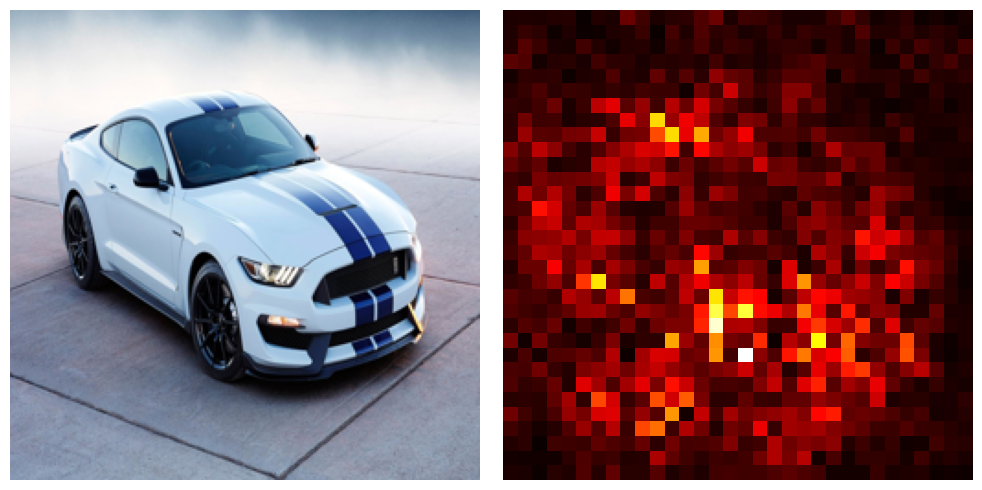

In [11]:
# CELLA 9: Saliency (vanilla)

import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# Verifica se le librerie principali sono disponibili
try:
    import matplotlib.pyplot
    import numpy
except ImportError as e:
    print(f"🔴 Errore import librerie base (matplotlib/numpy): {e}")
    saliency_available = False
else:
    saliency_available = True

#  Wrapper Modello (Necessario per fissare la domanda)
if 'VQAModelWrapper' not in globals():
    # print("⚠️ VQAModelWrapper non definito, lo ridefinisco...") # Rimosso per pulizia
    class VQAModelWrapper(nn.Module):
        def __init__(self, model: VQANet, question_embedding: torch.Tensor):
            super().__init__()
            self.model = model
            self.q_emb = question_embedding.clone().detach().to(DEVICE)
        def forward(self, x: torch.Tensor) -> torch.Tensor:
            B = x.size(0)
            q = self.q_emb.expand(B, -1)
            return self.model(x, q)

#  Funzione per Calcolare Vanilla Saliency
def get_vanilla_saliency(model_wrapper, input_tensor, target_class_idx):
    """Calcola la mappa di salienza (gradienti input)."""
    input_tensor_copy = input_tensor.clone().detach().requires_grad_(True)
    model_wrapper.eval()
    model_wrapper.zero_grad()

    output = model_wrapper(input_tensor_copy)
    score = output[0, target_class_idx]
    score.backward()

    saliency = input_tensor_copy.grad.data.abs()
    saliency, _ = torch.max(saliency, dim=1)
    saliency = saliency.squeeze(0).cpu().numpy()
    saliency = (saliency - np.min(saliency)) / (np.max(saliency) - np.min(saliency) + 1e-8)
    return saliency

def run_and_visualize_saliency(image_path: str, question: str, model: VQANet, device: str):
    """
    Carica immagine, esegue inferenza, calcola e mostra
    l'immagine originale e la saliency map affiancate, senza testi descrittivi.
    """
    global embedding_model

    try:
        rgb_img = Image.open(image_path).convert('RGB')
        transform = get_image_transform(is_training=False)
        input_tensor = transform(rgb_img).unsqueeze(0).to(device)
    except FileNotFoundError:
        print(f"🔴 ERRORE: Immagine non trovata: {image_path}")
        return
    except Exception as e:
        print(f"🔴 ERRORE caricamento/trasformazione immagine: {e}")
        return


    vis_img = np.array(rgb_img.resize((256, 256))) / 255.0

    if 'embedding_model' not in globals() or embedding_model is None:
         print("🔴 ERRORE: Modello embedding non caricato.")
         return

    q_emb = embedding_model.encode(question, convert_to_tensor=True, normalize_embeddings=False)
    if q_emb.dim() == 1: q_emb = q_emb.unsqueeze(0)
    q_emb = q_emb.to(device).float()

    wrapped_model = VQAModelWrapper(model, q_emb).to(device)

    # Ottieni Predizione (solo per l'indice target)
    with torch.no_grad():
        output = wrapped_model(input_tensor)
        pred_idx = output.argmax(1).item()

    # Calcola Saliency Map
    saliency_map = get_vanilla_saliency(wrapped_model, input_tensor, pred_idx)

    # Crea una figura con due subplot affiancati
    plt.figure(figsize=(10, 5)) # Larghezza maggiore per i due plot

    # Subplot di sinistra: Immagine Originale
    plt.subplot(1, 2, 1)
    plt.imshow(vis_img)
    plt.axis('off') # Rimuovi gli assi

    # Subplot di destra: Saliency Map
    plt.subplot(1, 2, 2)
    plt.imshow(saliency_map, cmap='hot')
    plt.axis('off') # Rimuovi gli assi

    # Non c'è alcun titolo generale o sottotitolo come richiesto
    plt.tight_layout() # Ottimizza il layout per evitare sovrapposizioni
    plt.show()


if saliency_available:
    if 'model' in globals() and Path(USER_IMAGE_PATH).exists():
        print(f"\n⚙️ Generazione Vanilla Saliency Map per '{USER_IMAGE_PATH}'...")
        run_and_visualize_saliency(USER_IMAGE_PATH, user_question_2, model, DEVICE)
    else:
        print("🔴 Impossibile generare Saliency Map: Modello non caricato o immagine non trovata.")
else:
    print("⚠️ Librerie necessarie (matplotlib/numpy) non importate. Visualizzazione Saliency saltata.")